In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Flatten, Dense, Input, 
                                     Dropout, BatchNormalization,
                                     Conv2D, MaxPooling2D, 
                                     GlobalMaxPooling2D, GlobalAveragePooling2D)

from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [2]:
model_path = '../../weight/Xception_v1.h5'
# label 字典
label_df = pd.read_csv('dict_df.csv')

In [3]:
input_tensor = Input(shape=(229, 229, 3))
model = keras.applications.Xception(include_top=False, 
                                    weights='imagenet',
                                    input_tensor=input_tensor,
                                    pooling=None,
                                    classes=800)
x = model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(800, activation='softmax')(x)
model = Model(inputs=model.input, outputs=predictions)
# load weights
model.load_weights(model_path)

In [4]:
def cv_show(img, name='image'):
    cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def preproc_img(img):
    
    #灰階 二質化
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # 消除水平 & 垂直直線
    inv = 255 - binary
    horizontal_img = inv
    vertical_img = inv
   
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100,1))
    horizontal_img = cv2.erode(horizontal_img, kernel, iterations=1)
    horizontal_img = cv2.dilate(horizontal_img, kernel, iterations=1)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,100))
    vertical_img = cv2.erode(vertical_img, kernel, iterations=1)
    vertical_img = cv2.dilate(vertical_img, kernel, iterations=1)

    mask_img = (horizontal_img + vertical_img)
    no_border = cv2.bitwise_or(binary, mask_img)
    # 消除 w, h完全空白的區域
    del_list_1 = []
    del_list_2 = []

    for i in range(no_border.shape[1]):
        if np.all(no_border[:, i] > 250):
            del_list_1.append(i)        

    for j in range(no_border.shape[0]):
        if np.all(no_border[j, :] > 250):
            del_list_2.append(j)

    no_space = np.delete(no_border, del_list_1, axis=1)   
    no_space = np.delete(no_space, del_list_2, axis=0)  
    # resize後輸出
    result = cv2.resize(no_space, (229, 229))

    return result


In [5]:
def pred_plt(img, label_df):    
    """ 切分圖片並預測, 取最大值
        @img_pre: 前處理後的圖
        @ label_df: label對照字典
    """
    # 複製五張圖片, 並做遮罩
    # 左1/3, 左2/3, 原圖, 右2/3, 右1/3
    cut = 3    
    point = 229 // 3
    cnt = cut * 2 - 1
    result_1 = img.copy()
    result_2 = img.copy()
    result_3 = img.copy()
    result_4 = img.copy()
    result_5 = img.copy()

    result_1[:, point:] = 255
    result_2[:, point*2:] = 255
    result_4[:, :point] = 255
    result_5[:, :point*2] = 255
    
    # 分別進行預測並記錄prob & label
    pred_max_prob_list = []
    pred_word_list = []
    img_list = []
    for i in range(1, cnt+1):
        img = cv2.cvtColor(eval(f'result_{i}'), cv2.COLOR_GRAY2BGR)        
        img = img.reshape(-1, 229, 229, 3)
        img_list.append(img[0])
        pred = model.predict(img)
        pred_max = np.argmax(pred)
        pred_max_prob = pred[:, np.argmax(pred)][0]
        pred_word = label_df[label_df['label'] == pred_max]['word'].values[0]
    
        pred_max_prob_list.append(pred_max_prob)
        pred_word_list.append(pred_word)
    # 取最大值
    max_idx = pred_max_prob_list.index(max(pred_max_prob_list))
    max_word = pred_word_list[max_idx]
    max_prob = pred_max_prob_list[max_idx]
    print(f'predict label: {max_word}')
    print(f'prob: {max_prob}')
    print('\n')
    for w, p in zip(pred_word_list, pred_max_prob_list):
        print(f'{w}: {p}')
    
    res = np.vstack((img_list[0], img_list[1], img_list[2], img_list[3], img_list[4]))
    plt.imshow(res)
    return res

In [6]:
img_folder = r'C:\Users\jason\Desktop\python\01_project\09_esun_2021\multiword'

In [7]:
f_list = os.listdir(img_folder)
img_list = []
for f in f_list:
    img= cv2.imread(f'{img_folder}/{f}')    
    img = preproc_img(img)
    img_list.append(img)

img_ary = np.array(img_list)

predict label: 生
prob: 0.9961007833480835


凱: 0.6398907899856567
女: 0.36158841848373413
姚: 0.6933115720748901
體: 0.7971341013908386
生: 0.9961007833480835
Wall time: 7.5 s


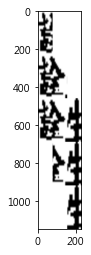

In [8]:
%%time
res = pred_plt(img_ary[22], label_df)

predict label: 宋
prob: 0.9713643193244934


律: 0.36013999581336975
音: 0.5229774117469788
木: 0.49302417039871216
宋: 0.9713643193244934
大: 0.47015953063964844
Wall time: 471 ms


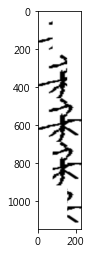

In [9]:
%%time
path = r'C:\Users\jason\Desktop\python\01_project\09_esun_2021\data-clean\0\1027.jpg'
img = cv2.imread(path)
img = preproc_img(img)
res = pred_plt(img, label_df)